In [1]:
import torch

import tr_util
import util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from Dimploma.EnvironmentTree import EnvInfo, MatrixEnvInfo, EnvMinimalTreeTwoStep
from Dimploma.ppo_parallel_custom import Agent
from Dimploma.utils.graph_provider import GraphProvider
from Dimploma.utils.my_agent_base import RandomAgent
from Dimploma.utils.testingResult import TestCorrelResult
from zNetwork.my_gcn import GCN
from zNetwork.fully_con import FCN
from zNetwork.hybrid_gcn import HybridNetworkGlobal

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Generate graphs of the given size
node_amount = 100
node_features = 2
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = int(max_edge_amount*0.75)
# edge_features = 2
edge_features = None

min_edge_val = 1
max_edge_val = 10


main_layers = 3
side_graph_layers = 6
main_lin_layers = 2
p_layers = 2
v_layers = 2

use_argmax = False

# if GCN
use_catenation = False


In [131]:
max_edge_amount

1225

In [4]:
graph_provider = GraphProvider(nodes=node_amount, edges=edge_amount, min_val=min_edge_val, max_val=max_edge_val)

graph_env = EnvMinimalTreeTwoStep(EnvInfo(graph_provider))
matrix_env = EnvMinimalTreeTwoStep(MatrixEnvInfo(graph_provider, edge_info=True, node_info=True))

In [94]:

loaded_graph = torch.load('graphs/graph23_n10_e33.pt', weights_only=False)
graph_provider.set_fixed_graph(loaded_graph)

In [5]:
# Agents setup
gcn_net = GCN(node_amount, node_features, use_catenation, main_layers, p_layers, v_layers, edge_dim=edge_features)
gcn6_net = GCN(node_amount, node_features, use_catenation, side_graph_layers, p_layers, v_layers, edge_dim=edge_features)
matrix_net = FCN(node_amount, node_features, edge_amount, main_lin_layers, p_layers, v_layers, True, True)
hybrid_net = HybridNetworkGlobal(node_features, node_amount, edge_dim=edge_features)

gcn_agent = Agent(gcn_net, test=True)
gcn6_agent = Agent(gcn6_net, test=True)
matrix_agent = Agent(matrix_net, test=True)
hybrid_agent = Agent(hybrid_net, test=True)


In [6]:
# test_amount = 64
test_amount = 100
graph_amount = 100
# graph_amount = 10

append = -1
# append = 40


tests = TestCorrelResult(node_amount, test_amount, graph_amount, append=append)

random_uniform = RandomAgent()
# tests.addAgent('Random', random_uniform, 'red', multiple_tetst=True)
tests.addAgent('GCN', gcn_agent, 'orange', multiple_tetst=True)
tests.addAgent('GCN6', gcn6_agent, 'brown', multiple_tetst=True)
tests.addAgent('Matrix', matrix_agent, 'magenta', multiple_tetst=True, special=True)
tests.addAgent('Hybrid', hybrid_agent, 'yellow', multiple_tetst=True)


In [7]:
tests.setup('logits_6')
tests.test(graph_env, matrix_env, use_argmax)

Started tests
Graph 0------------------------------
Started tests for agent GCN
Started tests for agent GCN6
Started tests for agent Matrix
Started tests for agent Hybrid
Finished 1 tests for all agents
Graph 1------------------------------
Started tests for agent GCN
Started tests for agent GCN6
Started tests for agent Matrix
Started tests for agent Hybrid
Finished 2 tests for all agents
Graph 2------------------------------
Started tests for agent GCN
Started tests for agent GCN6
Started tests for agent Matrix
Started tests for agent Hybrid
Finished 3 tests for all agents
Graph 3------------------------------
Started tests for agent GCN
Started tests for agent GCN6
Started tests for agent Matrix
Started tests for agent Hybrid
Finished 4 tests for all agents
Graph 4------------------------------
Started tests for agent GCN
Started tests for agent GCN6
Started tests for agent Matrix
Started tests for agent Hybrid
Finished 5 tests for all agents
Graph 5------------------------------
Sta

In [5]:
# default_path = 'results/correl/logits_6_n100_t100'
default_path = 'results/correl/logits_100_n100_t100'
# default_path = 'results/correl/actions_n10_t100'
default_path

'results/correl/logits_100_n100_t100'

In [6]:
actions_gcn_df = pd.read_csv(f'{default_path}/gcn_actions.csv', index_col=0)
actions_fcn_df = pd.read_csv(f'{default_path}/matrix_actions.csv', index_col=0)
actions_hybrid_df = pd.read_csv(f'{default_path}/hybrid_actions.csv', index_col=0)
logits_gcn = actions_gcn_df['correlation'].to_numpy()
logits_hybrid = actions_hybrid_df['correlation'].to_numpy()
logits_fcn = actions_fcn_df['correlation'].to_numpy()

# actions_random_df = pd.read_csv(f'{default_path}/random_actions.csv', index_col=0)
# degrees_df = pd.read_csv(f'{default_path}/degrees.csv', index_col=0)
# logits_gcn

In [7]:
view_limit = 0
view_limit_max = 10

names = [f'G{i + view_limit}' for i in range(min(logits_gcn.shape[0], view_limit_max - view_limit))]
names

['G0', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9']

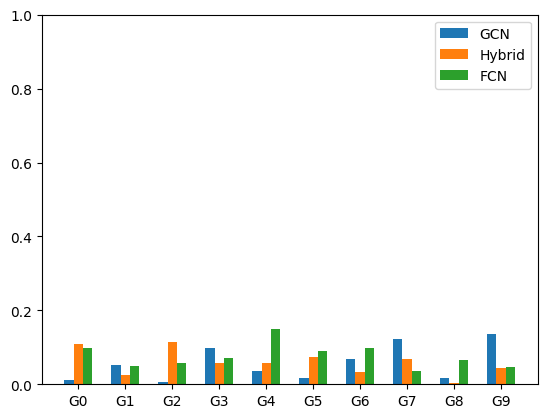

In [9]:
# colors = ['orange', 'brown', 'yellow', 'red']
# agent_names = ['GCN', 'Hybrid', 'FCN', 'Random']

x = np.arange(len(names))
width = 0.2


plt.bar(x - width, abs(logits_gcn[view_limit:view_limit_max]), width, label='GCN')
plt.bar(x, abs(logits_hybrid[view_limit:view_limit_max]), width, label='Hybrid')
plt.bar(x + width, abs(logits_fcn[view_limit:view_limit_max]), width, label='FCN')

# for i in range(len(correlations)):
#     plt.bar(x + i * width, correlations[i], width=width, label=agent_names[i], color=colors[i])

plt.ylim(0, 1)
plt.xticks(x, names)
plt.legend()
plt.show()

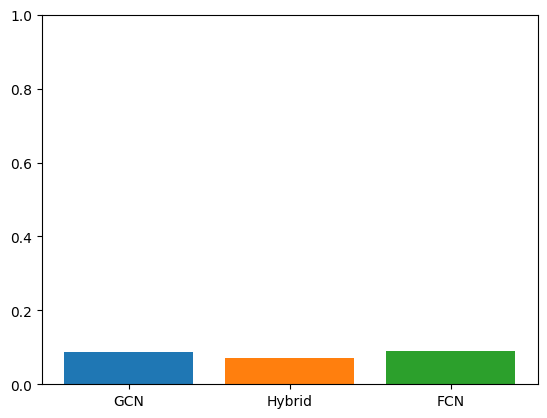

In [10]:
cor_gcn = abs(logits_gcn).mean()
cor_hybrid = abs(logits_hybrid).mean()
cor_fcn = abs(logits_fcn).mean()

plt.bar(0, cor_gcn, label='GCN')
plt.bar(1, cor_hybrid, label='Hybrid')
plt.bar(2, cor_fcn, label='FCN')

plt.ylim(0, 1)
plt.xticks([0, 1, 2], ['GCN', 'Hybrid', 'FCN'])

# plt.legend()
plt.show()
